In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import defaultdict

from market.exchange.exchange import Exchange

from market.trader.trader import Trader
from market.trader.market_maker import MarketMaker
from market.trader.sma import SMATrader

import torch
from decimal import Decimal
from market.order.order import Order

## Set up exchange

In [2]:
class RLTrader(Trader):
    def __init__(self, name: str, trader_id: str):
        super().__init__(name, trader_id, Decimal(1000), Decimal(100), 'RL Trader')
        self.model = torch.load('/Users/varun/Library/Mobile Documents/com~apple~CloudDocs/fyp2/market/rl/log/policy.pth')

    def decide(self, exchange: Exchange):
        prices = list(map(lambda x: float(x), list(exchange.recent_history)[-100:]))
        if len(prices) < 100:
            return None
        cash = float(self.cash)
        assets = float(self.assets)
        
        inputs = torch.tensor(prices + [cash] + [assets]).float()
        action = self.model(inputs).argmax().item()
        if action == 0:
            return Order(Decimal(prices[-1]), Decimal(-5), self.id)
        elif action == 1:
            return None
        elif action == 2:
            return Order(Decimal(prices[-1]), Decimal(5), self.id)

In [3]:
class SUPTrader(Trader):
    def __init__(self, name: str, trader_id: str):
        super().__init__(name, trader_id, Decimal(1000), Decimal(100), 'Supervised Trader')
        self.model = torch.load('/Users/varun/Library/Mobile Documents/com~apple~CloudDocs/fyp2/market/rl/log/policy_sup_single.pth')

    def decide(self, exchange: Exchange):
        prices = list(map(lambda x: float(x), list(exchange.recent_history)[-100:]))
        if len(prices) < 100:
            return None
        cash = float(self.cash)
        assets = float(self.assets)
        
        inputs = torch.tensor(prices).float()
        action = self.model(inputs).argmax().item()
        if action == 0:
            return Order(Decimal(prices[-1]), Decimal(-5), self.id)
        elif action == 1:
            return None
        elif action == 2:
            return Order(Decimal(prices[-1]), Decimal(5), self.id)

In [4]:
traders = []

mms = 20
for i in range(mms):
    traders.append(MarketMaker(f"mm{i}", f"mm{i}", volume=10))

rls = 4
for i in range(rls):
    traders.append(RLTrader(f'rl{i}', f'rl{i}'))

sups = 4
for i in range(sups):
    traders.append(SUPTrader(f'rl{i}', f'rl{i}'))

smas = 4
for i in range(smas):
    traders.append(SMATrader(f'sma{i}', f'sma{i}'))

## Add logging

In [5]:
exchange = Exchange("Text exchange", traders)

## Run exchange

In [6]:
exchange.run(400, progress_bar=True)
print(exchange.trades)

100%|██████████| 400/400 [00:03<00:00, 103.58it/s]

9383


## Display results

In [7]:
def display_l2_order_book(l2_book, ax, **kwargs):
    bids = np.array(list(l2_book['bids'].items())).transpose().astype('float64')
    asks = np.array(list(l2_book['asks'].items())).transpose().astype('float64')

    if len(bids) == 0 or len(asks) == 0:
        return

    bids_vals, bids_weights = bids[0], -bids[1]
    asks_vals, asks_weights = asks[0], asks[1]

    if len(bids) > 0:
        ax.axvline(x=bids[0][0], c='green', alpha=0.5, linestyle='dashed')
        ax.hist(bids_vals, weights=bids_weights, label="bids", color='green', bins=np.arange(min(bids_vals), max(bids_vals), 0.05),  **kwargs)
    if len(asks) > 0:
        ax.axvline(x=asks[0][0], c='red', alpha=0.5, linestyle='dashed')
        ax.hist(asks_vals, weights=asks_weights, label="asks", color='red', bins=np.arange(min(asks_vals), max(asks_vals), 0.05), **kwargs)
    ax.axhline(y=0, c='black', alpha=0.5, linestyle='dashed')

    ax.legend()

In [8]:
def display_asset_graph(log_file: str, ax, smoothing=1, **kwargs):
    data = pd.read_csv(log_file, index_col=0)
    rolled = data.rolling(smoothing, min_periods=1).mean()[smoothing-1:]
    ax.plot(rolled['close'], **kwargs)

In [9]:
def display_trader_profits(traders: dict[str: list[Trader]], asset_prices, ax, **kwargs):
    start, end = asset_prices
    def get_profit(trader, start, end):
        return (trader.cash + trader.assets * end) - (trader.initial_cash + trader.initial_assets * start)
    names = [key for key in traders.keys()]
    profits = [[get_profit(trader, start, end) for trader in traders[key]] for key in traders.keys()]
    ax.hist(profits, **kwargs, label=names)
    ax.axvline(x=0, c='black', alpha=0.5, linestyle='dashed')

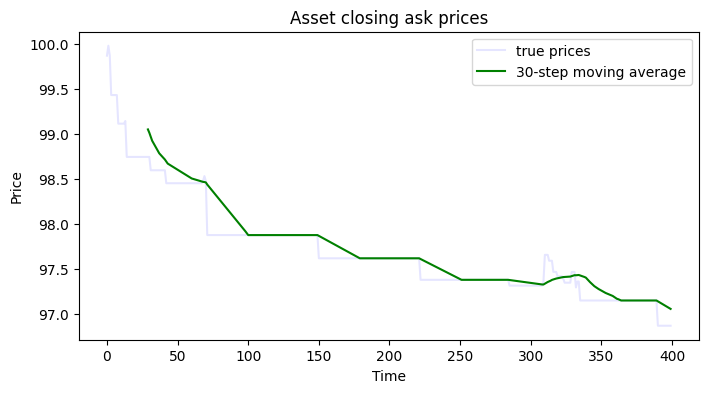

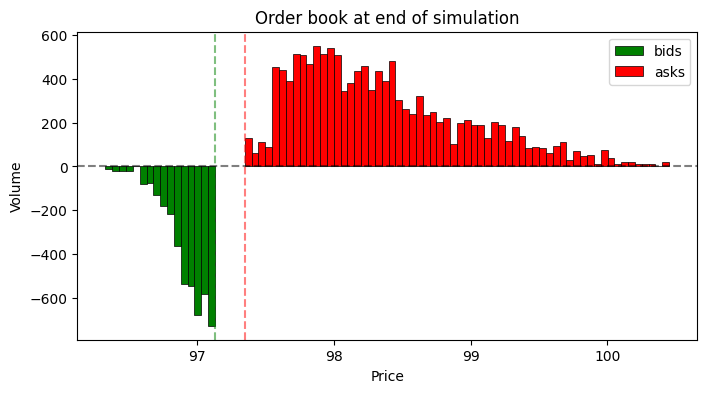

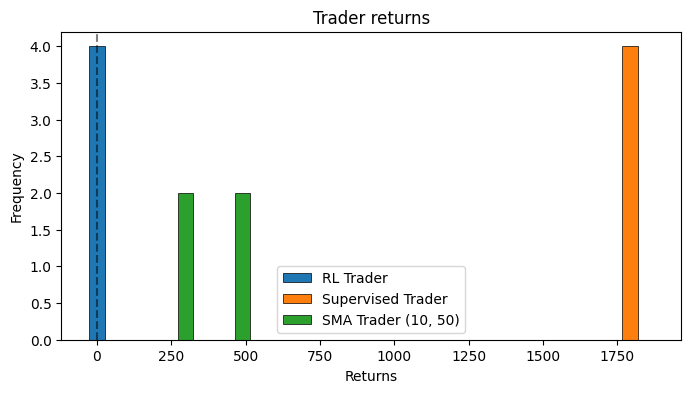

In [10]:
_, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Asset closing ask prices')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
display_asset_graph('/Users/varun/Library/Mobile Documents/com~apple~CloudDocs/fyp2/tmp/log.csv', ax, smoothing=1, c='blue', alpha=0.1, label='true prices')
# display_asset_graph('/Users/varun/Library/Mobile Documents/com~apple~CloudDocs/fyp2/tmp/log.csv', ax, smoothing=10, c='red', alpha=0.6, label='10-step moving average')
display_asset_graph('/Users/varun/Library/Mobile Documents/com~apple~CloudDocs/fyp2/tmp/log.csv', ax, smoothing=30, c='green', label='30-step moving average')
ax.legend()

_, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Order book at end of simulation')
ax.set_xlabel('Price')
ax.set_ylabel('Volume')
ob = exchange.orderbook.to_l2_dict()
display_l2_order_book(ob, ax, edgecolor='black', linewidth=0.5)
ax.legend()

_, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Trader returns')
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')
traders_dict = defaultdict(list[Trader])
for trader in traders:
    traders_dict[trader.trader_type].append(trader)
del traders_dict['Market maker']
display_trader_profits(traders_dict, (exchange.recent_history[0], exchange.recent_history[-1]), ax, edgecolor='black', linewidth=0.5)
ax.legend()

plt.show()